# Introduction

Title: Machine Learning Methods on Detecting Fraudulent Click Traffic for Mobile App Ads

## Abstract

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. TalkingData, China’s largest independent big data service platform, they handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. To help develop their solution one step further, I join the Kaggle competition to build an efficient machine learning algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support the modeling, TalkingData has provided a generous dataset covering approximately 200 million clicks.

## Description of dataset

1. TalkingData provides the dataset including both the training set and test set, which is accessible from Kaggle. <br>
2. The dataset is stored as “.csv” file. Three files are included: “train.csv” refers to the full training set, “train_sample.csv” refers to 100,000 randomly-selected rows of training data in order to inspect data before training on the full set, “test.csv” refers to the test set.<br>
3. In the dataset, each row of the training data contains a click record, with the following features. <br>
“ip”: ip address of click, <br>
“app”: app id for marketing, <br>
“device”: device type id of user mobile phone e.g., iphone 6 plus, iphone 7, etc, <br>
“os”: os version id of user mobile phone, <br>
“channel”: channel id of mobile ad publisher,<br>
“click_time”: timestamp of click (UTC), <br>
“attributed_time”: if user download the app for after clicking an ad, this is the time of the app download, <br>
“is_attributed”: the target that is to be predicted, indicating the app was downloaded. <br>

## Machine Learning Methods

The task is to predict whether the app was downloaded based on user’s portfolio. Basically, this is a binary classification problem of supervised learning. I consider using several ML algorithms such as KNN, SVM, Logistic regression, Naïve Bayesian, etc. to find the best algorithm with optimal parameters. 

## Result Evaluation

The accuracy score and confusion matrix will be used to measure the success of the prediction. 

## Gantt Diagram

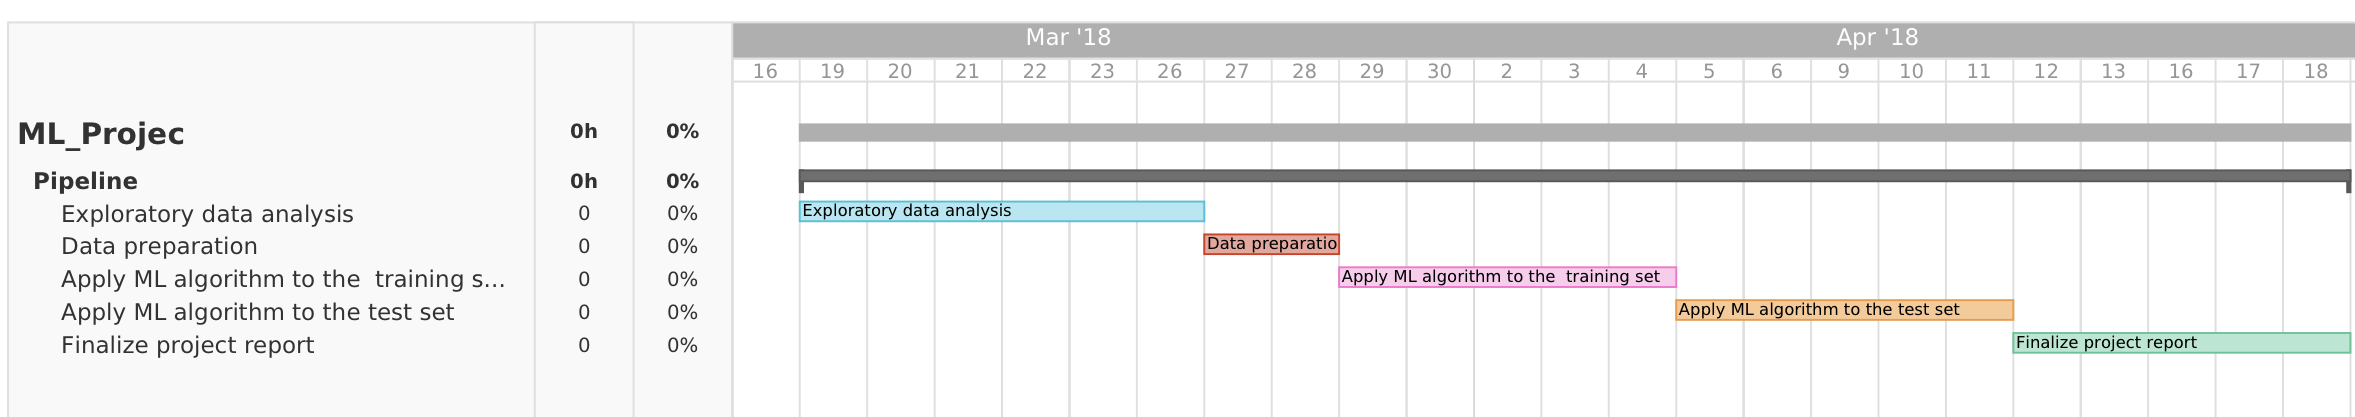

## Machine Learning Pipeline

1. Exploratory data analysis, visualize data to gain thoughts, including histogram plots, variable correlation plots.
2. Prepare the data, e.g., handling text and categorical input attributes, transform numerical data (standardizing, dealing with missing values). 
3. Split the training data set into k folds for cross-validation and start building scikit-learn pipelines.
4. Apply ML algorithm (classifier, e.g., SGDClassifier, SVM, etc) to training data set, hyperparameter tuning (use grid search, random search CV), and feature selection to find the optimal classifier set for the training data set.
5. Apply the optimized ML algorithm (classifier) to the test data set, report the accuracy score and confusion matrix. 
6. Summarize the report including the findings of investigating the data, the prediction accuracy of the test set, and the comparison of different models by performing significance test to test which ML pipeline is better.


# Phase 1

In [495]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from scipy.stats import reciprocal, uniform
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
color = sns.color_palette()
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import Imputer, LabelEncoder, StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier

In [401]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [402]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [403]:
def ttest(control, treatment):
    #paired t-test; two-tailed p-value      A   ,    B
    (t_score, p_value) = stats.ttest_rel(control, treatment)

    if p_value > 0.05/2:  #Two sided 
        print('There is no significant difference between the two machine learning pipelines (Accept H0)')
    else:
        print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
        if t_score > 0.0: #in the case of regression lower RMSE is better; A is lower 
            print('Machine learning pipeline A is better than B')
        else:
            print('Machine learning pipeline B is better than A')
    return p_value

## Obtain training sample data

Here I use the training sample data, "train_sample.csv" - 100,000 randomly-selected rows of training data, to inspect data before analysing the full set.

Show some data in the training set

In [404]:
sample_file='/root/shared/Dropbox/Class-2018-Spring/projects/talking_data/train_sample/train_sample.csv'
data=pd.read_csv(sample_file)
data = shuffle(data) # shuffle training data set
data.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
23681,101429,22,1,22,116,2017-11-08 06:26:19,NaN,0
54259,41753,14,1,13,118,2017-11-08 02:34:10,NaN,0
16309,120613,12,1,41,265,2017-11-09 13:46:46,NaN,0
13949,116377,12,1,19,328,2017-11-07 08:48:38,NaN,0
89999,55893,1,1,19,124,2017-11-06 18:53:21,NaN,0


Show some examples that is "is_attributed".

In [405]:
data[data['is_attributed']==1].head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
65519,297552,29,1,10,213,2017-11-09 12:37:24,2017-11-09 12:40:10,1
60639,260439,29,1,10,333,2017-11-08 13:48:31,2017-11-08 13:49:55,1
30073,5348,19,40,24,213,2017-11-09 10:47:39,2017-11-09 10:47:54,1
25742,157074,35,1,13,274,2017-11-07 03:00:36,2017-11-07 03:33:02,1
14946,160155,29,1,19,101,2017-11-07 07:30:54,2017-11-07 07:31:15,1


In [410]:
y_data=data['is_attributed'].copy()
data_train, data_test=train_test_split(data,test_size=0.2, random_state=42,stratify=y_data)

## Updated: Balancing imblanced data using Random Over-Sampling

0    0.99773
1    0.00227
Name: is_attributed, dtype: float64


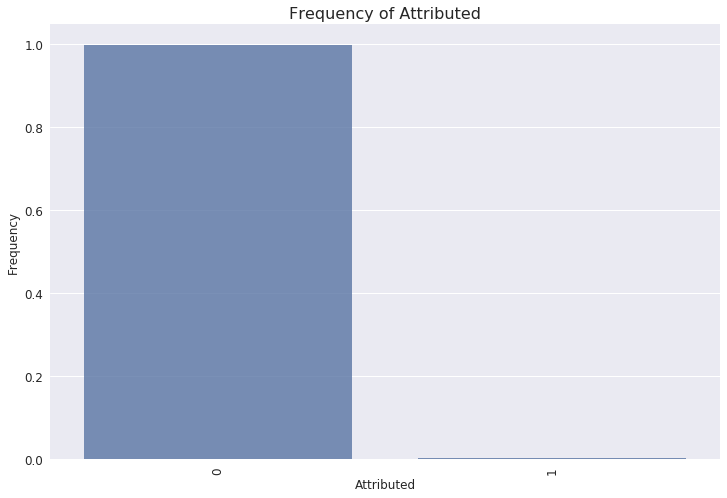

In [433]:
group_df=data.is_attributed.value_counts().reset_index()
total=data['is_attributed'].sum()
plt.figure(figsize = (12,8))
sns.barplot(group_df['index'], (group_df.is_attributed/len(data)), alpha=0.8, color=color[0])
print((group_df.is_attributed/len(data)))
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Attributed', fontsize = 12)
plt.title('Frequency of Attributed', fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()

In [411]:
print('Attributed class ratio:',len(data_train[data_train['is_attributed']==1])/len(data_train))

Attributed class ratio: 0.002275


In [412]:
print('Attributed class ratio:',len(data_test[data_test['is_attributed']==1])/len(data_test))

Attributed class ratio: 0.00225


The targeted attributed class ratio is only 0.00227, implying this is heavily imblanced data. Here we used Random over-sampling to balance the data set.

Over-Sampling increases the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample.<br>
https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/
* Advantages<br>
(1) Unlike under sampling this method leads to no information loss.<br>
(2) Outperforms under sampling.<br>
* Disadvantages<br>
(1) It increases the likelihood of overfitting since it replicates the minority class events.

In [471]:
train_sample=data_train
test_sample=data_test
rare_class=data_train[data_train['is_attributed']==1]
print(len(rare_class))
for i in range(0,99):
    temp = [train_sample, rare_class]
    train_sample=pd.concat(temp)
print(len(train_sample[train_sample['is_attributed']==1]))

182
18200


In [472]:
print(len(train_sample[train_sample['is_attributed']==1])/len(train_sample[train_sample['is_attributed']==0]))

0.22801874263950486


In [473]:
train_sample = shuffle(train_sample)
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
51638,196491,35,1,22,274,2017-11-09 09:01:35,2017-11-09 09:18:23,1
65264,156351,9,1,17,134,2017-11-06 23:32:48,NaN,0
72974,66313,3,1,19,452,2017-11-09 02:04:40,NaN,0
88945,286739,9,2,10,466,2017-11-08 12:49:58,NaN,0
51203,41866,2,2,100,477,2017-11-08 10:19:01,NaN,0


In [475]:
train_sample['app']= train_sample['app'].astype('uint16')
train_sample['channel'] =train_sample['channel'].astype('uint16')
train_sample['device'] = train_sample['device'].astype('uint16')
train_sample['ip'] = train_sample['ip'].astype('uint32')
train_sample['os'] = train_sample['os'].astype('uint16')

In [479]:
test_sample = shuffle(test_sample)
test_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
61264,5348,12,1,19,135,2017-11-09 07:02:18,NaN,0
64055,104366,12,1,23,245,2017-11-07 08:05:50,NaN,0
58311,83906,15,1,35,140,2017-11-07 16:03:55,NaN,0
32249,44951,2,1,47,477,2017-11-06 18:11:33,NaN,0
82340,68134,12,1,18,205,2017-11-08 08:27:33,NaN,0


In [481]:
test_sample['app'] = test_sample['app'].astype('uint16')
test_sample['channel'] = test_sample['channel'].astype('uint16')
test_sample['device'] = test_sample['device'].astype('uint16')
test_sample['ip'] = test_sample['ip'].astype('uint32')
test_sample['os'] = test_sample['os'].astype('uint16')

## Exploratory Data Analysis (EDA)

Here I perform a barplot for the distribution of attributed

98018
0    0.81432
1    0.18568
Name: is_attributed, dtype: float64


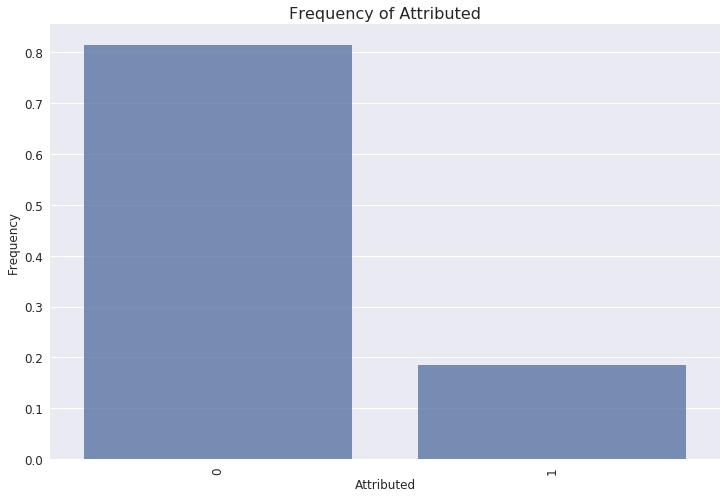

In [434]:
group_df=train_sample.is_attributed.value_counts().reset_index()
print(len(train_sample.is_attributed))
total=train_sample['is_attributed'].sum()
plt.figure(figsize = (12,8))
sns.barplot(group_df['index'], (group_df.is_attributed/len(train_sample)), alpha=0.8, color=color[0])
print((group_df.is_attributed/len(train_sample)))
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Attributed', fontsize = 12)
plt.title('Frequency of Attributed', fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()

After random over sampling, as is shown in the barplot, the portion of attributed and non-attributed is 0.18568 and  0.81432, showing the portion of attributed class is now balanced. 

* Process click_time variable

In [435]:
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
15821,5348,19,0,29,213,2017-11-07 14:17:49,2017-11-07 14:17:52,1
20774,104530,3,1,13,130,2017-11-06 23:55:42,NaN,0
48774,63812,2,1,8,469,2017-11-08 15:59:22,NaN,0
32202,75318,3,1,17,280,2017-11-07 06:09:13,NaN,0
85260,211412,15,1,13,245,2017-11-08 02:41:23,NaN,0


In [436]:
train_sample['click_time'] = pd.to_datetime(train_sample['click_time'])
train_sample['hour'] = train_sample['click_time'].dt.hour.astype('uint8')
train_sample['day'] = train_sample['click_time'].dt.day.astype('uint8')
train_sample['second'] = train_sample['click_time'].dt.second.astype('uint8')
train_sample=train_sample.drop(['click_time'], axis =1)

In [482]:
test_sample['click_time'] = pd.to_datetime(test_sample['click_time'])
test_sample['hour'] = test_sample['click_time'].dt.hour.astype('uint8')
test_sample['day'] = test_sample['click_time'].dt.day.astype('uint8')
test_sample['second'] = test_sample['click_time'].dt.second.astype('uint8')
test_sample=test_sample.drop(['click_time'], axis =1)

In [437]:
train_sample.head()

,ip,app,device,os,channel,attributed_time,is_attributed,hour,day,second
15821,5348,19,0,29,213,2017-11-07 14:17:52,1,14,7,49
20774,104530,3,1,13,130,NaN,0,23,6,42
48774,63812,2,1,8,469,NaN,0,15,8,22
32202,75318,3,1,17,280,NaN,0,6,7,13
85260,211412,15,1,13,245,NaN,0,2,8,23


In [438]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98018 entries, 15821 to 32818
Data columns (total 10 columns):
ip                 98018 non-null uint32
app                98018 non-null uint16
device             98018 non-null uint16
os                 98018 non-null uint16
channel            98018 non-null uint16
attributed_time    18200 non-null object
is_attributed      98018 non-null int64
hour               98018 non-null uint8
day                98018 non-null uint8
second             98018 non-null uint8
dtypes: int64(1), object(1), uint16(4), uint32(1), uint8(3)
memory usage: 6.1+ MB


* Remove "attributed_time" variable as it does not exist in test set

In [483]:
train_sample=train_sample.drop('attributed_time',axis=1)
test_sample=test_sample.drop('attributed_time',axis=1)

* Plot of number of unique values per feature

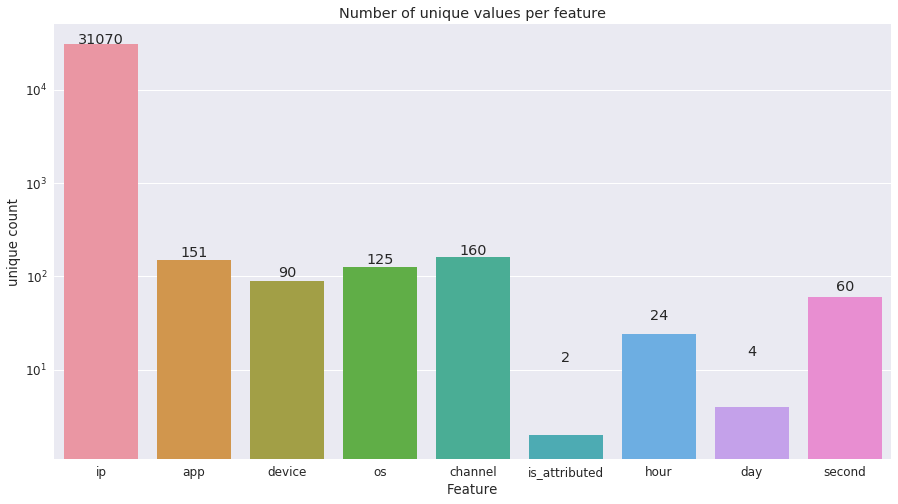

In [440]:
plt.figure(figsize=(15, 8))
cols = list(train_sample)
uniques = [len(train_sample[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='unique count', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
plt.show()

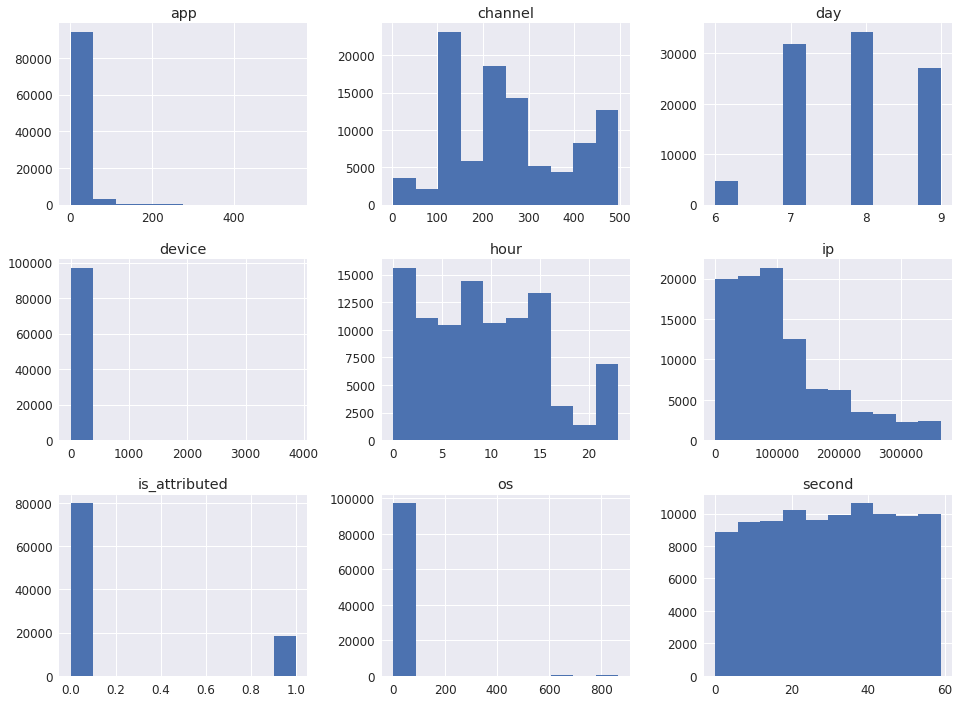

In [441]:
train_sample.hist(figsize=(16,12))
plt.show()

* Calculate the Correlation coefficient of features 

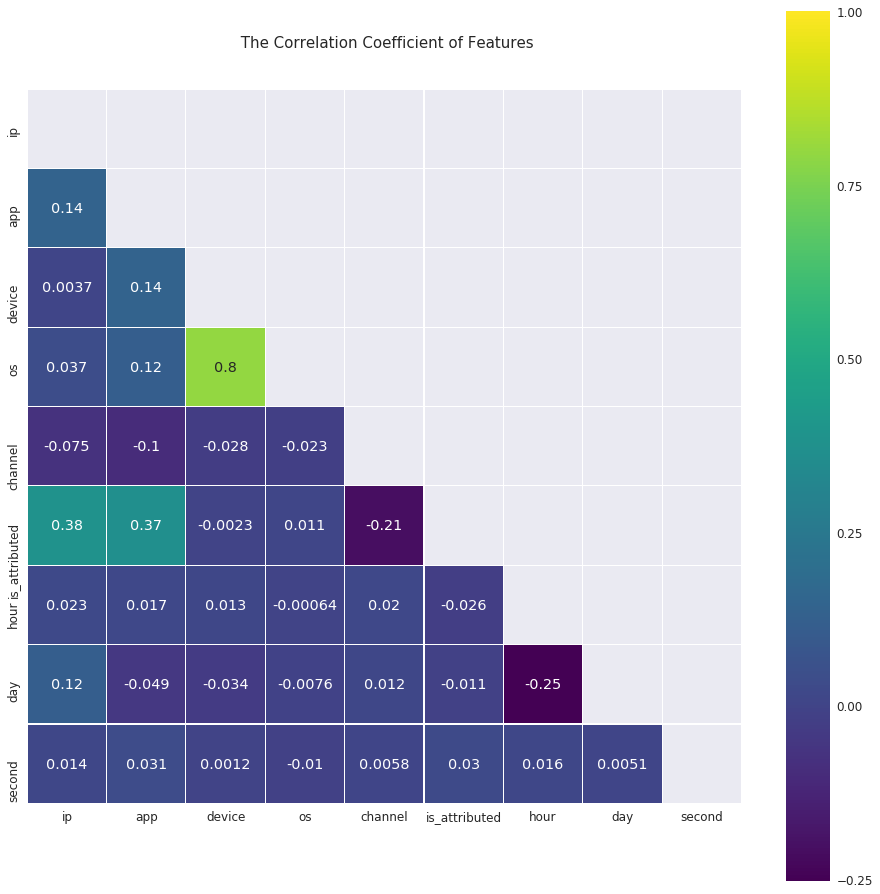

In [442]:
colormap = plt.cm.viridis
corr=train_sample.astype(float).corr()
# generate a mask for the lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(16,16))
plt.title(' The Correlation Coefficient of Features', y=1.05, size=15)
sns.heatmap(corr,mask=mask,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, )
plt.show()

* From the correlation plot, we find "ip" and "app" have highest correlation with "is_attributed".

* Kernel density plot of the variables 

count     98018.000000
mean     106310.724520
std       83870.815915
min           9.000000
25%       43999.000000
50%       87868.500000
75%      141244.000000
max      364757.000000
Name: ip, dtype: float64


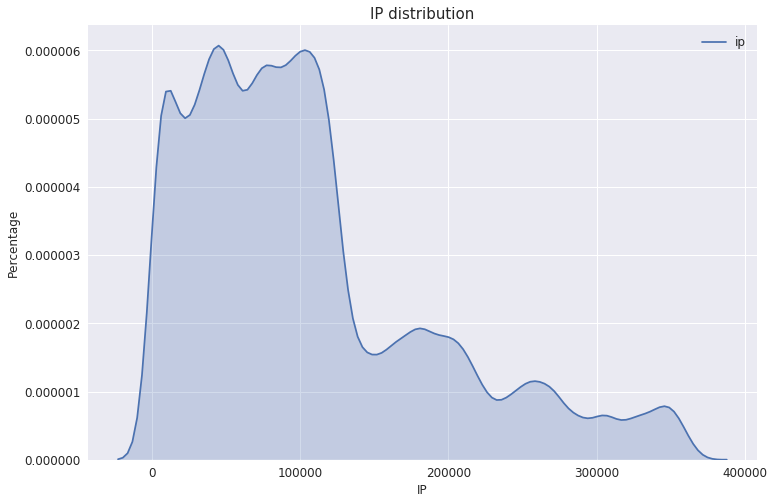

In [443]:
print(train_sample.ip.describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(train_sample.ip, shade=True)
plt.title('IP distribution', fontsize = 15)
plt.xlabel('IP', fontsize = 12)
plt.ylabel('Percentage', fontsize = 12)
plt.show()

count    98018.000000
mean        15.788223
std         21.644272
min          1.000000
25%          3.000000
50%         12.000000
75%         18.000000
max        551.000000
Name: app, dtype: float64


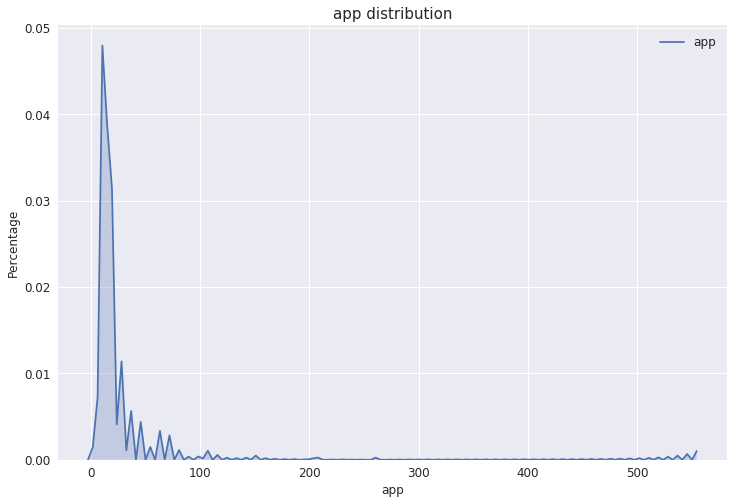

In [444]:
print(train_sample.app.describe())
plt.figure(figsize=(12, 8))
sns.kdeplot(train_sample.app, shade=True)
plt.title('app distribution', fontsize = 15)
plt.xlabel('app', fontsize = 12)
plt.ylabel('Percentage', fontsize = 12)
plt.show()

count    98018.000000
mean        20.937144
std        234.867593
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       3867.000000
Name: device, dtype: float64
count    98018.000000
mean        22.961425
std         56.790483
min          0.000000
25%         13.000000
50%         18.000000
75%         20.000000
max        866.000000
Name: os, dtype: float64
count    98018.000000
mean       255.880971
std        130.517831
min          3.000000
25%        135.000000
50%        244.000000
75%        371.000000
max        497.000000
Name: channel, dtype: float64


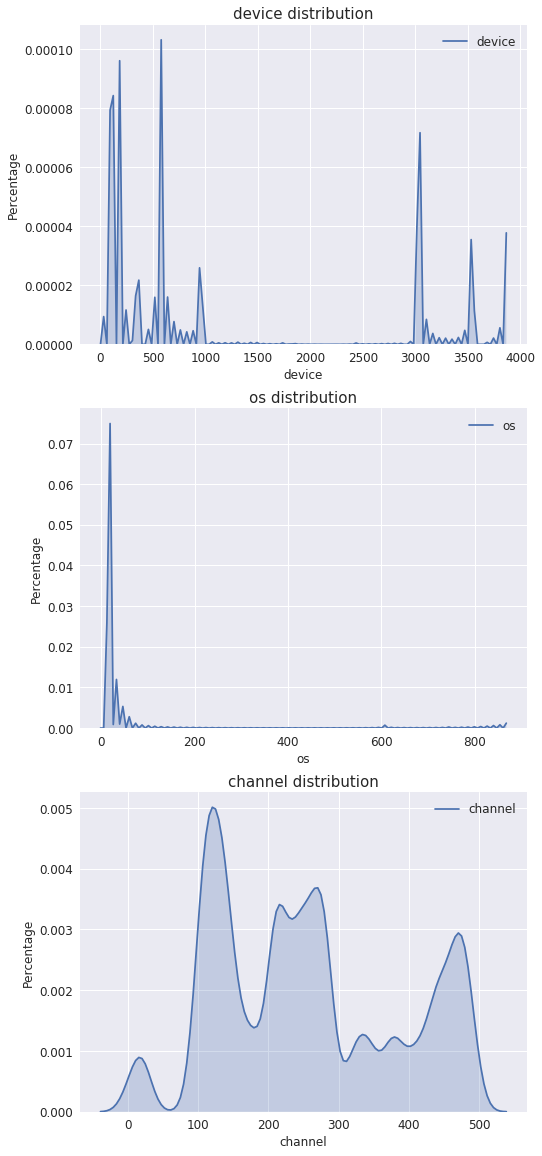

In [445]:
print(train_sample.device.describe())
print(train_sample.os.describe())
print(train_sample.channel.describe())
plt.figure(figsize=(8, 20))
plt.subplot(311)
sns.kdeplot(train_sample.device, shade=True)
plt.title('device distribution', fontsize = 15)
plt.xlabel('device', fontsize = 12)
plt.ylabel('Percentage', fontsize = 12)
plt.subplot(312)
sns.kdeplot(train_sample.os, shade=True)
plt.title('os distribution', fontsize = 15)
plt.xlabel('os', fontsize = 12)
plt.ylabel('Percentage', fontsize = 12)
plt.subplot(313)
sns.kdeplot(train_sample.channel, shade=True)
plt.title('channel distribution', fontsize = 15)
plt.xlabel('channel', fontsize = 12)
plt.ylabel('Percentage', fontsize = 12)
plt.show()

Divide the training data into X_train and y_labels

In [484]:
X_train_sample=train_sample.drop(['is_attributed'],axis=1)
y_train_sample=train_sample['is_attributed'].copy()
X_test_sample=test_sample.drop(['is_attributed'],axis=1)
y_test_sample=test_sample['is_attributed'].copy()

In [447]:
X_train_sample.head()

,ip,app,device,os,channel,hour,day,second
15821,5348,19,0,29,213,14,7,49
20774,104530,3,1,13,130,23,6,42
48774,63812,2,1,8,469,15,8,22
32202,75318,3,1,17,280,6,7,13
85260,211412,15,1,13,245,2,8,23


In [448]:
y_train_sample.head()

15821    1
20774    0
48774    0
32202    0
85260    0
Name: is_attributed, dtype: int64

In [449]:
cols=list(X_train_sample)
cols

['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 'second']

## Baseline model (SGDClassifier)

* Split the tranning data into training and test set

In [450]:
X_train, X_test, y_train, y_test=train_test_split(X_train_sample,y_train_sample,test_size=0.2, random_state=42,stratify=y_train_sample)

* Create a base pipeline prediction using SGDClassifier 

In [485]:
param_grid = [
    {'sgd_clf__penalty': ['l1','l2'], 'sgd_clf__alpha': [0.01,0.001,0.0001]},
  ]

pipeline_pred = Pipeline([('sgd_clf',SGDClassifier(loss='log'))])
sgd_grid_search = GridSearchCV(pipeline_pred, param_grid, cv=5,
                           scoring='accuracy')
sgd_grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('sgd_clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'sgd_clf__penalty': ['l1', 'l2'], 'sgd_clf__alpha': [0.01, 0.001, 0.0001]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [486]:
sgd_model=sgd_grid_search.best_estimator_

## Model evaluation matrix

Here we use the best model estimator to predict the training and test set data and evaluate the model performance using accuracy score and confusion matrix. 

In [487]:
# predict the training and test set 
sgd_preds_train=sgd_model.predict(X_train)
sgd_preds_test =sgd_model.predict(X_test)
sgd_preds_test_r=sgd_model.predict(X_test_sample)

In [488]:
class_labels=['non-attributed','attributed']

In [489]:
sgd_cm_train = confusion_matrix(y_train, sgd_preds_train).astype(np.float64)
sgd_cm_train /= sgd_cm_train.sum(axis=1)[:, np.newaxis]

sgd_cm_test = confusion_matrix(y_test, sgd_preds_test).astype(np.float64)
sgd_cm_test /= sgd_cm_test.sum(axis=1)[:, np.newaxis]

sgd_cm_test_r = confusion_matrix(y_test_sample, sgd_preds_test_r).astype(np.float64)
sgd_cm_test_r /= sgd_cm_test_r.sum(axis=1)[:, np.newaxis]

In [490]:
print(sgd_cm_train)

[[ 0.988  0.012]
 [ 0.921  0.079]]


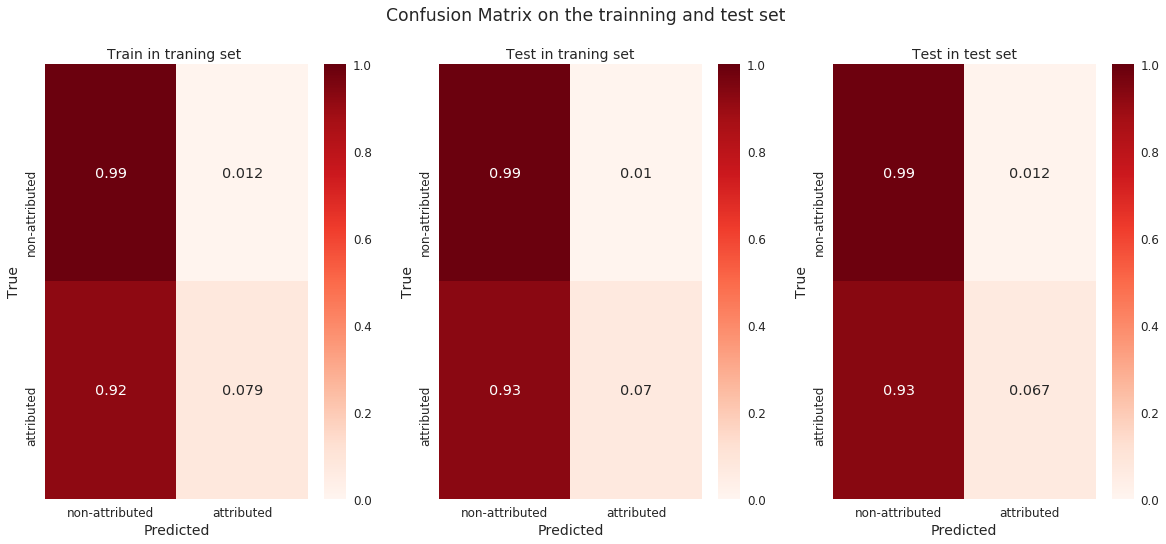

In [491]:
plt.figure(figsize=(20, 8))
plt.suptitle('Confusion Matrix on the trainning and test set')
plt.subplot(131)
g = sns.heatmap(sgd_cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train in traning set ", fontsize=14)

plt.subplot(132)
g = sns.heatmap(sgd_cm_test, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in traning set", fontsize=14);

plt.subplot(133)
g = sns.heatmap(sgd_cm_test_r, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in test set", fontsize=14);
plt.show()

In [492]:
print("The prediction accuracy score for training set in training sample is ",accuracy_score(y_train, sgd_preds_train))
print("The prediction accuracy score for test set in training sample is ",accuracy_score(y_test, sgd_preds_test))
print("The prediction accuracy score for test set in test sample is ",accuracy_score(y_test_sample, sgd_preds_test_r))

The prediction accuracy score for training set in training sample is  0.81944550718
The prediction accuracy score for test set in training sample is  0.819118547235
The prediction accuracy score for test set in test sample is  0.98615


In [496]:
print("The prediction f1 score for training set in training sample is ",f1_score(y_train, sgd_preds_train))
print("The prediction f1 score for test set in training sample is ",f1_score(y_test, sgd_preds_test))
print("The prediction f1 score for test set in test sample is ",f1_score(y_test_sample, sgd_preds_test_r))

The prediction f1 score for training set in training sample is  0.139121974948
The prediction f1 score for test set in training sample is  0.126170527353
The prediction f1 score for test set in test sample is  0.0212014134276


Show predictions that are predicted as class "attributed".

In [494]:
print(sgd_preds_train[sgd_preds_train==1])
print(sgd_preds_test[sgd_preds_test==1])
print(sgd_preds_test_r[sgd_preds_test_r==1])

[1 1 1 ..., 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

## Report 

1. Here we finished the data collection, initial EDA and transformation of variables. 
2. From the correlation plot, we find "ip" and "app" have highest correlation with "is_attributed". 
3. Almost all the data in the training and test set are predicted as non-attributed, though the accuracy socre is high, while the model is not applicable. 

# Phase 2

In this phase, we created new features and build another predcition model using SVM and obatin the best esitimators to improve the predcition accuracy. 

## Feature engineering 

In [462]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,hour,day,second
15821,5348,19,0,29,213,1,14,7,49
20774,104530,3,1,13,130,0,23,6,42
48774,63812,2,1,8,469,0,15,8,22
32202,75318,3,1,17,280,0,6,7,13
85260,211412,15,1,13,245,0,2,8,23


Here we created a series of new features to see whether they are correlated with the targeted prediction class. Here we created the following features: <br>
the number of counts of channel for each ip at the same weekday and hour; <br>
the number of counts of channel for each ip using same app;<br>
the number of counts of channel for each ip using same app and os;<br>
the number of counts of channel for each ip using same app at the same day and hour;<br>
the average hour for each ip using same app at the same channel.<br>

In [497]:
X_train_m=X_train
X_test_m=X_test
X_test_r_m=test_sample

In [498]:
# Define all the groupby transformations

# Modified and adapted from https://www.kaggle.com/tetyanayatsenko/prepare-data-form-features-find-their-importance
GROUPBY_AGGREGATIONS = [

    # Count, for ip-day-hour
    {'groupby': ['ip','day','hour'], 'select': 'channel', 'agg': 'count', 'type': 'uint32'},    
    # Count, for ip-app
    {'groupby': ['ip', 'app'], 'select': 'channel', 'agg': 'count', 'type': 'uint32'},        
    # Count, for ip-app-os
    {'groupby': ['ip', 'app', 'os'], 'select': 'channel', 'agg': 'count', 'type': 'uint32'},
    # Count, for ip-app-day-hour
    {'groupby': ['ip','app','day','hour'], 'select': 'channel', 'agg': 'count', 'type': 'uint32'},    
    # Mean hour, for ip-app-channel
    {'groupby': ['ip','app','channel'], 'select': 'hour', 'agg': 'mean', 'type': 'float32', 'type': 'float32'}
]
# Apply all the groupby transformations

for spec in GROUPBY_AGGREGATIONS:
    print(f"Grouping by {spec['groupby']}, and aggregating {spec['select']} with {spec['agg']}")
    # Unique list of features to select
    all_features = list(set(spec['groupby'] + [spec['select']]))
    # Name of new feature
    new_feature = '{}_{}_{}'.format('_'.join(spec['groupby']), spec['agg'], spec['select'])
     # Perform the groupby
    gp_train = X_train_m[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature}).astype(spec['type'])
    gp_test = X_test_m[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature}).astype(spec['type']) 
    gp_test_r = X_test_r_m[all_features]. \
        groupby(spec['groupby'])[spec['select']]. \
        agg(spec['agg']). \
        reset_index(). \
        rename(index=str, columns={spec['select']: new_feature}).astype(spec['type']) 
     # Merge back to X_train and X_test
    X_train_m = X_train_m.merge(gp_train, on=spec['groupby'], how='left')
    X_test_m=X_test_m.merge(gp_test, on=spec['groupby'], how='left')
    X_test_r_m=X_test_r_m.merge(gp_test_r, on=spec['groupby'], how='left')
print("End")

Grouping by ['ip', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app'], and aggregating channel with count
Grouping by ['ip', 'app', 'os'], and aggregating channel with count
Grouping by ['ip', 'app', 'day', 'hour'], and aggregating channel with count
Grouping by ['ip', 'app', 'channel'], and aggregating hour with mean
End


In [465]:
X_train_m.head()

,ip,app,device,os,channel,hour,day,second,ip_day_hour_count_channel,ip_app_count_channel,ip_app_os_count_channel,ip_app_day_hour_count_channel,ip_app_channel_mean_hour
0,78293,3,1,14,280,6,7,19,1,1,1,1,6.0
1,23064,6,1,13,125,3,8,40,1,1,1,1,3.0
2,62617,11,1,41,481,0,9,14,1,1,1,1,0.0
3,77029,14,1,13,379,20,7,57,1,1,1,1,20.0
4,106820,3,1,25,424,22,8,24,1,2,1,1,22.0


## SVM model

Here we are using the support vector machine (SVM) as the model for feature selection, including hyperparameter tunning. 

In [499]:
print(list(X_train_m))

['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 'second', 'ip_day_hour_count_channel', 'ip_app_count_channel', 'ip_app_os_count_channel', 'ip_app_day_hour_count_channel', 'ip_app_channel_mean_hour']


In [500]:
# Identify the numeric features we wish to consider. 
num_attribs = ['app', 'device', 'os', 'channel', 'hour',
       'day','ip_day_hour_count_channel','ip_app_count_channel','ip_app_os_count_channel','ip_app_day_hour_count_channel','ip_app_channel_mean_hour']

# Create a pipeline for the numeric features.
# Missing values will be imputed using the feature median.
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()), 
        ('normalizer',Normalizer()),
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
    ])

In [501]:
X_train_m_ts = full_pipeline.fit_transform(X_train_m)
X_test_m_ts = full_pipeline.fit_transform(X_test_m)
X_test_r_m_ts = full_pipeline.fit_transform(X_test_r_m)

In [502]:
X_train_m.head()

,ip,app,device,os,channel,hour,day,second,ip_day_hour_count_channel,ip_app_count_channel,ip_app_os_count_channel,ip_app_day_hour_count_channel,ip_app_channel_mean_hour
0,78293,3,1,14,280,6,7,19,1,1,1,1,6.0
1,23064,6,1,13,125,3,8,40,1,1,1,1,3.0
2,62617,11,1,41,481,0,9,14,1,1,1,1,0.0
3,77029,14,1,13,379,20,7,57,1,1,1,1,20.0
4,106820,3,1,25,424,22,8,24,1,2,1,1,22.0


In [503]:
X_train_m_ts[0]

array([-0.344, -0.05 , -0.093,  0.109, -0.311, -0.569, -0.287, -0.306,
       -0.284, -0.281, -0.32 ])

In [504]:
param_grid = {"svc_clf__C": [0.5, 1, 2],
                "svc_clf__kernel":['linear']}

svc=Pipeline([
                ('svc_clf',SVC(random_state=42,probability=True))
            ])
svc_search_cv = GridSearchCV(svc, param_grid,scoring='f1')
svc_search_cv.fit(X_train_m_ts, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('svc_clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svc_clf__C': [0.5, 1, 2], 'svc_clf__kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [505]:
svm_model=svc_search_cv.best_estimator_

In [506]:
svm_preds_train=svm_model.predict(X_train_m_ts)
svm_preds_test=svm_model.predict(X_test_m_ts)
svm_preds_test_r=svm_model.predict(X_test_r_m_ts)

In [507]:
svm_cm_train = confusion_matrix(y_train, svm_preds_train).astype(np.float64)
svm_cm_train /= svm_cm_train.sum(axis=1)[:, np.newaxis]

svm_cm_test = confusion_matrix(y_test, svm_preds_test).astype(np.float64)
svm_cm_test /= svm_cm_test.sum(axis=1)[:, np.newaxis]

svm_cm_test_r = confusion_matrix(y_test_sample, svm_preds_test_r).astype(np.float64)
svm_cm_test_r /= svm_cm_test_r.sum(axis=1)[:, np.newaxis]

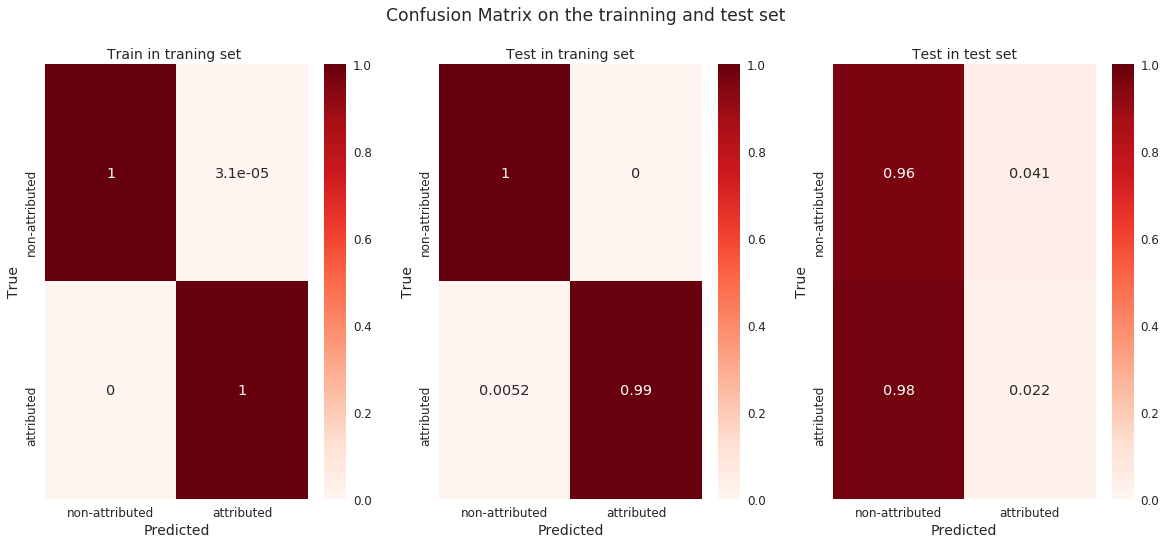

In [508]:
plt.figure(figsize=(20, 8))
plt.suptitle('Confusion Matrix on the trainning and test set')
plt.subplot(131)
g = sns.heatmap(svm_cm_train, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Train in traning set ", fontsize=14)

plt.subplot(132)
g = sns.heatmap(svm_cm_test, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in traning set", fontsize=14);

plt.subplot(133)
g = sns.heatmap(svm_cm_test_r, vmin=0, vmax=1, annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in test set", fontsize=14);
plt.show()

In [510]:
print("The prediction accuracy score for training set in training sample is ",accuracy_score(y_train, svm_preds_train))
print("The prediction accuracy score for test set in training sample is ",accuracy_score(y_test, svm_preds_test))
print("The prediction accuracy score for test set in test sample is ",accuracy_score(y_test_sample, svm_preds_test_r))

The prediction accuracy score for training set in training sample is  0.99997449435
The prediction accuracy score for test set in training sample is  0.999030810039
The prediction accuracy score for test set in test sample is  0.95725


In [511]:
print("The prediction f1 score for training set in training sample is ",f1_score(y_train, svm_preds_train))
print("The prediction f1 score for test set in training sample is ",f1_score(y_test, svm_preds_test))
print("The prediction f1 score for test set in test sample is ",f1_score(y_test_sample, svm_preds_test_r))

The prediction f1 score for training set in training sample is  0.999931323398
The prediction f1 score for test set in training sample is  0.99738328054
The prediction f1 score for test set in test sample is  0.00233372228705


In [512]:
print(len(y_train[y_train==1]),len(svm_preds_train[svm_preds_train==1]))
print(len(y_test[y_test==1]),len(svm_preds_test[svm_preds_test==1]))
print(len(y_test_sample[y_test_sample==1]),len(svm_preds_test_r[svm_preds_test_r==1]))

14560 14562
3640 3621
45 812


## Report

1. In this section, we added more features, e.g., counts of channels for ip-day-hour. I applied SVM classifier and use random grid search to tune the hyperparameters. Finally, the prediction accuracy improves a lot to reach almost 1.
2. In next phase I will apply feature selection and multiple model to improve the prediction.

# Phase 3

As we observed that both SGDClassifier and SVM model barely predicted the positive class. In this phase, we are going to dive into the issue and find methods to solve it.
In this phase, we apply various feature selection methods, multiple machine learning algorithms, ensemble learning methods and statistical significance test to compare the best model with baseline model.<br>
Major updates:
* applied feature selection methods
* applied multiple machine learning algorithms and compared the prediction accuracy
* applied ensemble learning methods
* statistical significance test to compare the best two models

## Feature selection 

Here I used several feature selection methods to select those features that have the strongest relationship with the output variable.

In [513]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Univariate Selection

First method we use for feature selection is called univariate selection from sklearn.
We select the top 5 features from the data set.

In [514]:
uni_slt = SelectKBest(k=5)
uni_slt_fit = uni_slt.fit(X_train_m_ts, y_train)
# summarize fitting scores
np.set_printoptions(precision=3)
print(uni_slt_fit.scores_)
uni_features = uni_slt_fit.transform(X_train_m_ts)
# summarize selected features
print(uni_features.shape)

[  1.526e+04   2.999e+03   1.024e+03   1.040e+03   1.447e+00   2.814e+01
   1.058e+06   4.024e+05   1.217e+06   1.276e+06   2.530e+00]
(78414, 5)


### Recursive Feature Elimination

Second method I use for feature selection is called Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.

In [515]:
# Feature Extraction with RFE
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 5)
rfe_fit = rfe.fit(X_train_m_ts, y_train)
print("Num Features: %d" % rfe_fit.n_features_)
print("Selected Features: %s" % rfe_fit.support_)
print("Feature Ranking: %s" % rfe_fit.ranking_)

Num Features: 5
Selected Features: [ True False False False False False  True  True  True  True False]
Feature Ranking: [1 3 2 6 4 5 1 1 1 1 7]


### Principal Component Analysis

Generally this is called a data reduction technique. A property of PCA is that we can choose the number of dimensions or principal component in the transformed result.<br>
In the example below, we use PCA and select 5 principal components.

In [517]:
from sklearn.decomposition import PCA
# feature extraction
pca = PCA(n_components=5)
X_train_m_ts_PCA=pca.fit_transform(X_train_m_ts)
X_test_m_ts_PCA=pca.fit_transform(X_test_m_ts)
X_test_r_m_ts_PCA=pca.fit_transform(X_test_r_m_ts)

## Feature Selection v.s. Feature Importance 

Here we performed Random Forest Classifier to estimate the importance of features.<br>
Then we compared the feature selection results. 

In [518]:
# Feature Importance with Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
etc_model = ExtraTreesClassifier()
etc_model.fit(X_train_m_ts, y_train)
print(etc_model.feature_importances_)

[  1.260e-02   2.667e-05   5.115e-03   2.244e-03   2.680e-03   7.303e-03
   1.101e-01   3.182e-01   3.533e-01   1.883e-01   1.333e-04]


## Applying multiple ML models via gridsearch

First we use the features of 5 principal components by PCA as input to test the multiple ML models, includding logistic regression, random forest, support vector machine, and KNN.

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 1.000
Test in training set accuracy score for best params: 0.998 
Test in training set precision score for best params: 0.996 
Test in training set recall score for best params: 0.996 
Test in training set f1 score for best params: 0.996 
Test in test set accuracy score for best params: 0.753 
Test in test set precision score for best params: 0.002 
Test in test set recall score for best params: 0.244 
Test in test set f1 score for best params: 0.004 


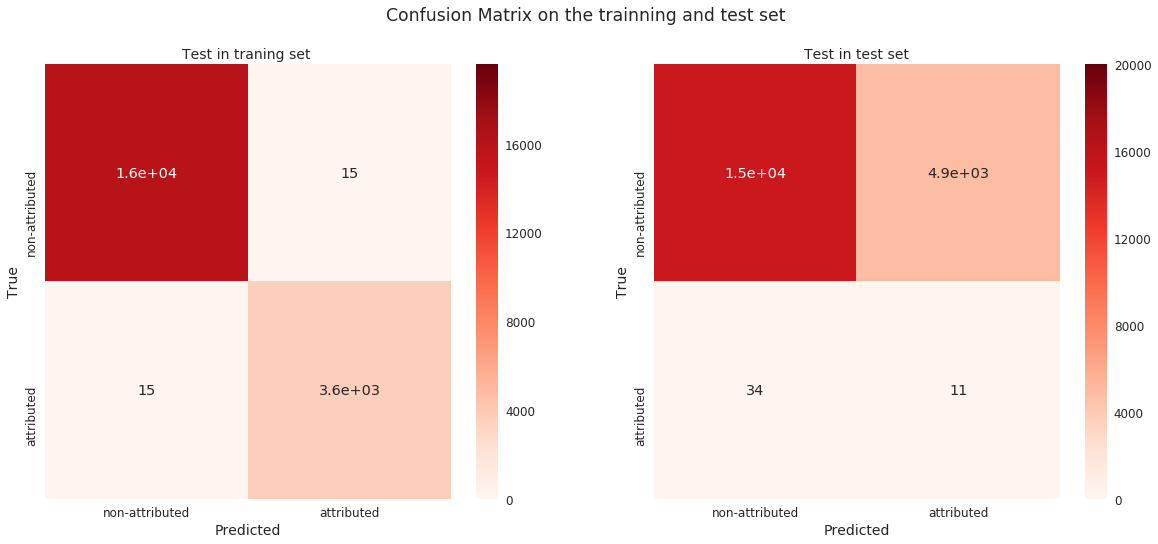


Estimator: Random Forest
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}
Best training accuracy: 1.000
Test in training set accuracy score for best params: 0.971 
Test in training set precision score for best params: 1.000 
Test in training set recall score for best params: 0.843 
Test in training set f1 score for best params: 0.915 
Test in test set accuracy score for best params: 0.880 
Test in test set precision score for best params: 0.002 
Test in test set recall score for best params: 0.089 
Test in test set f1 score for best params: 0.003 


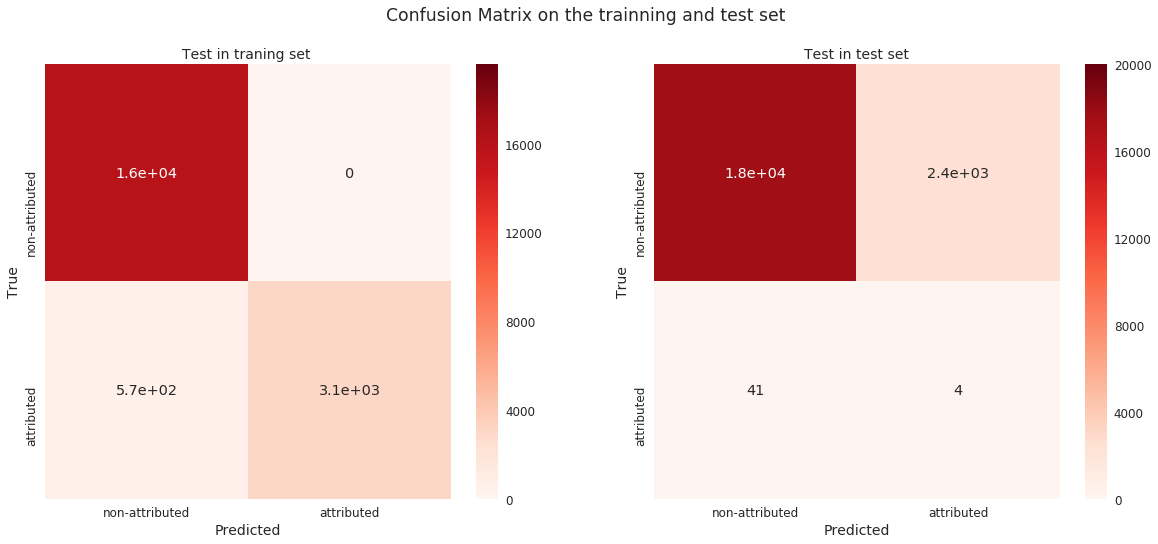


Estimator: Support Vector Machine
Best params: {'clf__C': 10, 'clf__kernel': 'rbf'}
Best training accuracy: 1.000
Test in training set accuracy score for best params: 0.998 
Test in training set precision score for best params: 0.996 
Test in training set recall score for best params: 0.993 
Test in training set f1 score for best params: 0.995 
Test in test set accuracy score for best params: 0.798 
Test in test set precision score for best params: 0.002 
Test in test set recall score for best params: 0.178 
Test in test set f1 score for best params: 0.004 


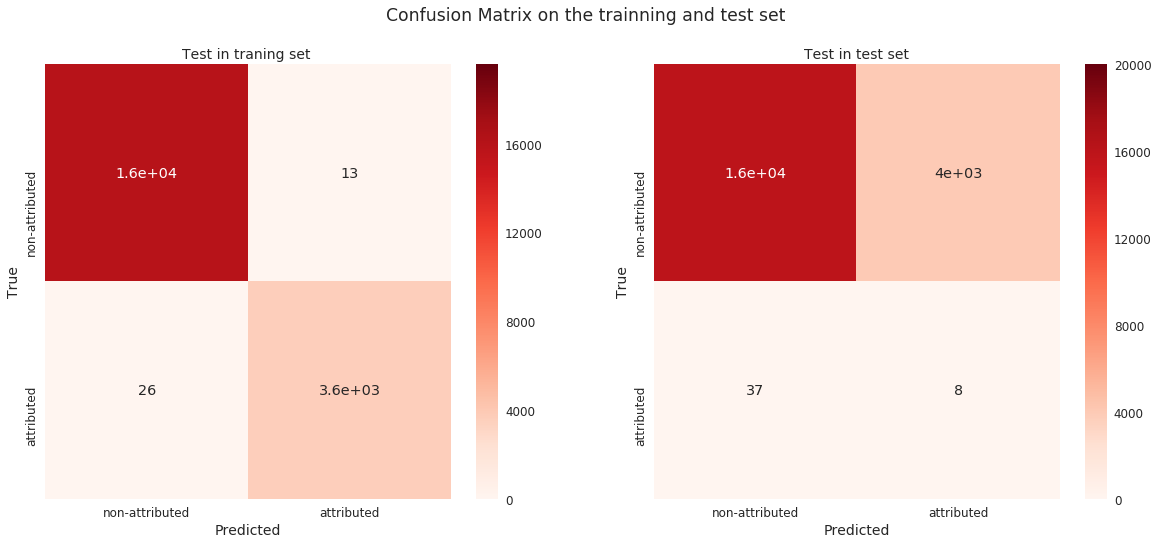


Estimator: K Nearest Neighbor
Best params: {'clf__n_neighbors': 3, 'clf__weights': 'uniform'}
Best training accuracy: 1.000
Test in training set accuracy score for best params: 0.998 
Test in training set precision score for best params: 1.000 
Test in training set recall score for best params: 0.991 
Test in training set f1 score for best params: 0.995 
Test in test set accuracy score for best params: 0.855 
Test in test set precision score for best params: 0.002 
Test in test set recall score for best params: 0.156 
Test in test set f1 score for best params: 0.005 


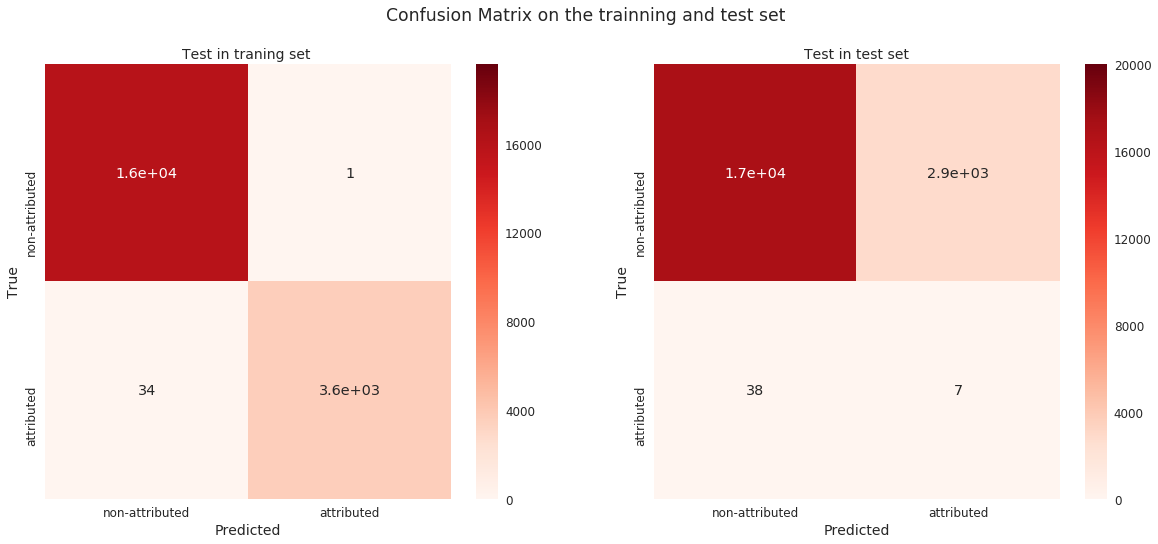


Classifier with best test set accuracy: Logistic Regression


In [563]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score,recall_score,f1_score

# Construct some pipelines
pipe_lr = Pipeline([('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('clf', SVC(random_state=42))])

pipe_knn = Pipeline([('clf',KNeighborsClassifier())])

#Set grid search params
param_range = [1,5,10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range}]

grid_params_knn = [{'clf__n_neighbors': [3, 5], 
        'clf__weights': ['uniform','distance']}]

gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10) 

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='accuracy',
            cv=10) 

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring='accuracy',
            cv=10) 

gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=grid_params_knn,
            scoring='accuracy',
            cv=10) 

# List of pipelines for ease of iteration
grids = [gs_lr, gs_rf, gs_svm, gs_knn]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 
        2: 'Support Vector Machine', 3: 'K Nearest Neighbor'}

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train_m_ts_PCA, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test_m_ts_PCA)
    y_pred_r = gs.predict(X_test_r_m_ts_PCA)
    # Test data accuracy of model with best params
    print('Test in training set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    print('Test in training set precision score for best params: %.3f ' % precision_score(y_test, y_pred,pos_label=1))
    print('Test in training set recall score for best params: %.3f ' % recall_score(y_test, y_pred,pos_label=1))
    print('Test in training set f1 score for best params: %.3f ' % f1_score(y_test, y_pred,pos_label=1))
    print('Test in test set accuracy score for best params: %.3f ' % accuracy_score(y_test_sample, y_pred_r))
    print('Test in test set precision score for best params: %.3f ' % precision_score(y_test_sample, y_pred_r,pos_label=1))
    print('Test in test set recall score for best params: %.3f ' % recall_score(y_test_sample, y_pred_r,pos_label=1))
    print('Test in test set f1 score for best params: %.3f ' % f1_score(y_test_sample, y_pred_r,pos_label=1))
    cm_test = confusion_matrix(y_test, y_pred).astype(np.float64)
    cm_test_r = confusion_matrix(y_test_sample, y_pred_r).astype(np.float64)
    
    plt.figure(figsize=(20, 8))
    plt.suptitle('Confusion Matrix on the trainning and test set')
    plt.subplot(121)
    g = sns.heatmap(cm_test, vmin=0, vmax=len(y_test), annot=True, cmap="Reds")
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    g.set(xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Test in traning set ", fontsize=14)

    plt.subplot(122)
    g = sns.heatmap(cm_test_r, vmin=0, vmax=len(y_test_sample), annot=True, cmap="Reds")
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)
    g.set(xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Test in test set", fontsize=14);
    plt.show()
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

## Sucess/Failure analysis

After we perform multiple machine learning algorithm using PCA generated features (5 principal components), we found all the results (confusion matrix) are still predicted as "non-attributed". In other words, very few data is predicted as positive class. This is a serious issue as the predictor does not classify the non-attributed and attributed class property. Since the true positive class in the data set only has 227 out of 100,000, this leads to a very high probability, the true positive class data are blinded. Therefore, I plan to implement a ensemble learning approach to see whether it will improve this issue. 

Updates from phase 4: After balancing the data, all the classifiers do very good job. Here we modified the prediction results below. Support Vector Machine is selected as the best model in terms of test set accuracy.

In [550]:
ml_results = pd.DataFrame(columns=["ExpID", "Data Description", "Accuracy","Precision","Recall", "F1 score"])
ml_results.loc[0] = ["Logistic Regression", "Test set for training",0.998, 0.996, 0.996, 0.996]
ml_results.loc[1] = ["Logistic Regression", "Real Test set", 0.753, 0.002, 0.244, 0.004]
ml_results.loc[2] = ["Random Forest", "Test set for training",0.971, 1.000, 0.843, 0.915]   
ml_results.loc[3] = ["Random Forest", "Real Test set", 0.880, 0.002, 0.089, 0.003]   
ml_results.loc[4] = ["Support Vector Machine", "Test set for training", 0.998, 0.996, 0.993, 0.995]
ml_results.loc[5] = ["Support Vector Machine",  "Real Test set", 0.798, 0.002, 0.178, 0.004]
ml_results.loc[6] = ["K Nearest Neighbor", "Test set for training", 0.998, 1.000, 0.991, 0.995]   
ml_results.loc[7] = ["K Nearest Neighbor", "Real Test set", 0.855, 0.002, 0.156, 0.005] 
ml_results

,ExpID,Data Description,Accuracy,Precision,Recall,F1 score
0,Logistic Regression,Test set for training,0.998,0.996,0.996,0.996
1,Logistic Regression,Real Test set,0.753,0.002,0.244,0.004
2,Random Forest,Test set for training,0.971,1.000,0.843,0.915
3,Random Forest,Real Test set,0.880,0.002,0.089,0.003
4,Support Vector Machine,Test set for training,0.998,0.996,0.993,0.995
5,Support Vector Machine,Real Test set,0.798,0.002,0.178,0.004
6,K Nearest Neighbor,Test set for training,0.998,1.000,0.991,0.995
7,K Nearest Neighbor,Real Test set,0.855,0.002,0.156,0.005


## Ensemble learning model 

To further improve the prediction performance, here we try different emsemble learning methods. 

### Voting Ensemble

We apply voting ensemble method to combine the predictions from above multiple machine learning algorithms.<br>
It works by first creating two or more standalone models from training dataset. A Voting Classifier can then be used to wrap the models and average the predictions of the sub-models when asked to make predictions for new data.<br>
The predictions of the sub-models can be weighted, but specifying the weights for classifiers manually or even heuristically is difficult.

In [535]:
enml_results = pd.DataFrame(columns=["ExpID", "Data Description", "Accuracy","Precision","Recall", "F1 score"])

In [522]:
# Voting Ensemble for Classification
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
kfold = model_selection.KFold(n_splits=30, random_state=42)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('dtc', model2))
model3 = SVC(probability=True)
estimators.append(('svm', model3))
# create the ensemble model
ve_model = VotingClassifier(estimators,voting='soft')
results_ve = model_selection.cross_val_score(ve_model, X_train_m_ts_PCA, y_train, scoring='f1',cv=kfold)
print(results_ve.mean())

0.9995486329


In [536]:
ve_model.fit(X_train_m_ts_PCA, y_train)
ve_y_pred=ve_model.predict(X_test_m_ts_PCA)
ve_y_pred_r=ve_model.predict(X_test_r_m_ts_PCA)

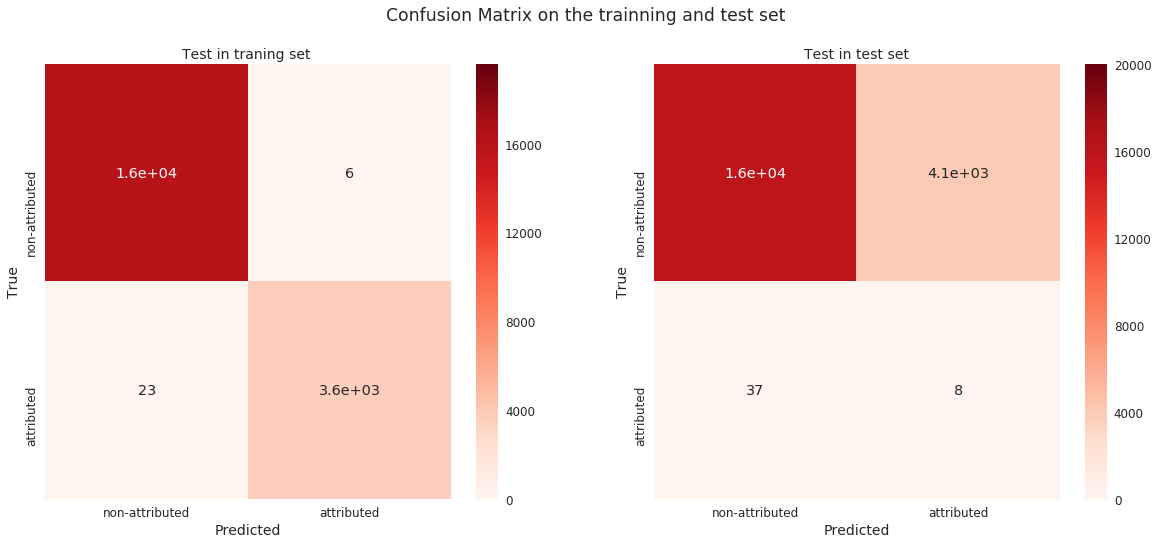

In [562]:
ve_test = confusion_matrix(y_test, ve_y_pred).astype(np.float64)
ve_test_r = confusion_matrix(y_test_sample, ve_y_pred_r).astype(np.float64)
plt.figure(figsize=(20, 8))
plt.suptitle('Confusion Matrix on the trainning and test set')
plt.subplot(121)
g = sns.heatmap(ve_test, vmin=0, vmax=len(y_test), annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in traning set ", fontsize=14)

plt.subplot(122)
g = sns.heatmap(ve_test_r, vmin=0, vmax=len(y_test_sample), annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in test set", fontsize=14);
plt.show()

In [538]:
enml_results.loc[0] = ["Voting Ensemble", "Test set for training", accuracy_score(y_test, ve_y_pred),precision_score(y_test, ve_y_pred,pos_label=1),recall_score(y_test, ve_y_pred,pos_label=1),f1_score(y_test, ve_y_pred,pos_label=1)]
enml_results.loc[1] = ["Voting Ensemble", "Real Test set", accuracy_score(y_test_sample, ve_y_pred_r),precision_score(y_test_sample, ve_y_pred_r,pos_label=1),recall_score(y_test_sample, ve_y_pred_r,pos_label=1),f1_score(y_test_sample, ve_y_pred_r,pos_label=1)]
enml_results

,ExpID,Data Description,Accuracy,Precision,Recall,F1 score
0,Voting Ensemble,Test set for training,0.998521,0.998344,0.993681,0.996007
1,Voting Ensemble,Real Test set,0.795350,0.001969,0.177778,0.003894


Here we test the voting ensemble model, combining logistic regression, decision tree and support vector machine and assigning different weights. The final prediction average accuracy on the training set is 999549.

### Boosting Algorithms

Here we try boosting algorithms, one of the ensemble learning methods to improve and evaluate the prediction performance.<br>
Boosting ensemble algorithms creates a sequence of models that attempt to correct the mistakes of the models before them in the sequence.<br>
Once created, the models make predictions which may be weighted by their demonstrated accuracy and the results are combined to create a final output prediction.

The two most common boosting ensemble machine learning algorithms are: AdaBoost and Stochastic Gradient Boosting. <br>
Stochastic Gradient Boosting (also called Gradient Boosting Machines) are one of the most sophisticated ensemble techniques. It is also a technique that is proving to be perhaps of the the best techniques available for improving performance via ensembles. Therefore, Here we choose Stochastic Gradient Boosting.<br>

In [525]:
from sklearn.ensemble import GradientBoostingClassifier
num_trees = 100
kfold = model_selection.KFold(n_splits=30, random_state=42)
gbc_model = GradientBoostingClassifier(n_estimators=num_trees, random_state=42)
results_gbc = model_selection.cross_val_score(gbc_model, X_train_m_ts_PCA, y_train, scoring='f1', cv=kfold)
print(results_gbc.mean())

0.999750339543


In [539]:
gbc_model.fit(X_train_m_ts_PCA, y_train)
gbc_y_pred=gbc_model.predict(X_test_m_ts_PCA)
gbc_y_pred_r=gbc_model.predict(X_test_r_m_ts_PCA)

In [540]:
enml_results.loc[2] = ["Boosting Ensemble", "Test set for training", accuracy_score(y_test, gbc_y_pred),precision_score(y_test, gbc_y_pred,pos_label=1),recall_score(y_test, gbc_y_pred,pos_label=1),f1_score(y_test, gbc_y_pred,pos_label=1)]
enml_results.loc[3] = ["Boosting Ensemble", "Real Test set", accuracy_score(y_test_sample, gbc_y_pred_r),precision_score(y_test_sample, gbc_y_pred_r,pos_label=1),recall_score(y_test_sample, gbc_y_pred_r,pos_label=1),f1_score(y_test_sample, gbc_y_pred_r,pos_label=1)]
enml_results

,ExpID,Data Description,Accuracy,Precision,Recall,F1 score
0,Voting Ensemble,Test set for training,0.998521,0.998344,0.993681,0.996007
1,Voting Ensemble,Real Test set,0.795350,0.001969,0.177778,0.003894
2,Boosting Ensemble,Test set for training,0.965364,1.000000,0.813462,0.897137
3,Boosting Ensemble,Real Test set,0.898800,0.002013,0.088889,0.003937


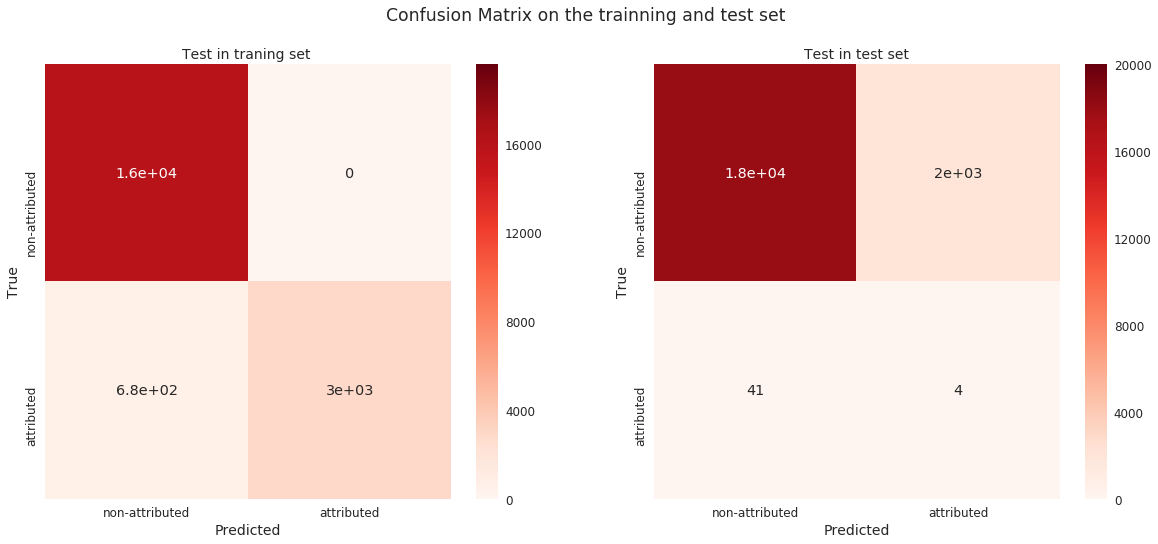

In [560]:
gbc_test = confusion_matrix(y_test, gbc_y_pred).astype(np.float64)
gbc_test_r = confusion_matrix(y_test_sample, gbc_y_pred_r).astype(np.float64)
plt.figure(figsize=(20, 8))
plt.suptitle('Confusion Matrix on the trainning and test set')
plt.subplot(121)
g = sns.heatmap(gbc_test, vmin=0, vmax=len(y_test), annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in traning set ", fontsize=14)

plt.subplot(122)
g = sns.heatmap(gbc_test_r, vmin=0, vmax=len(y_test_sample), annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in test set", fontsize=14);
plt.show()

Here we applied the boosting algorithm to the training set and the average prediction accuracy  is 0.999750.

### Bagging Algorithms

Here we try bagging algorithms, one of the ensemble learning methods to improve and evaluate the prediction performance.<br>
Bootstrap Aggregation or bagging involves taking multiple samples from your training dataset (with replacement) and training a model for each sample.<br>
The final output prediction is averaged across the predictions of all of the sub-models.<br>
There are three bagging models: Bagged Decision Trees,Random Forest, Extra Trees.<br>
Bagging performs best with algorithms that have high variance. A popular example are decision trees, often constructed without pruning.<br>
Here we are using the BaggingClassifier with the Classification and Regression Trees algorithm (DecisionTreeClassifier).

In [530]:
# Bagged Decision Trees for Classification
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

kfold = model_selection.KFold(n_splits=30, random_state=42)
cart = DecisionTreeClassifier()
num_trees = 100
bagg_model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=42)
results_bagg = model_selection.cross_val_score(bagg_model, X_train_m_ts_PCA, y_train, scoring='f1', cv=kfold)
print(results_bagg.mean())

0.999787090648


In [541]:
bagg_model.fit(X_train_m_ts_PCA, y_train)
bagg_y_pred=bagg_model.predict(X_test_m_ts_PCA)
bagg_y_pred_r=bagg_model.predict(X_test_r_m_ts_PCA)

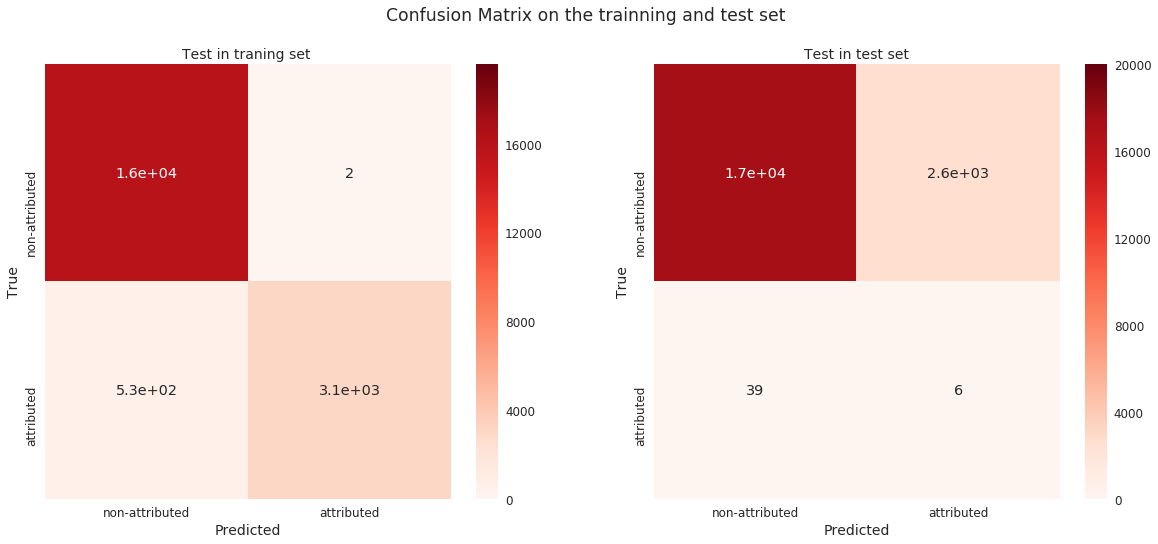

In [561]:
bagg_test = confusion_matrix(y_test, bagg_y_pred).astype(np.float64)
bagg_test_r = confusion_matrix(y_test_sample, bagg_y_pred_r).astype(np.float64)
plt.figure(figsize=(20, 8))
plt.suptitle('Confusion Matrix on the trainning and test set')
plt.subplot(121)
g = sns.heatmap(bagg_test, vmin=0, vmax=len(y_test), annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in traning set ", fontsize=14)

plt.subplot(122)
g = sns.heatmap(bagg_test_r, vmin=0, vmax=len(y_test_sample), annot=True, cmap="Reds")
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
g.set(xticklabels=class_labels, yticklabels=class_labels)
plt.title("Test in test set", fontsize=14);
plt.show()

In [542]:
enml_results.loc[4] = ["Bagging Ensemble", "Test set for training", accuracy_score(y_test, bagg_y_pred),precision_score(y_test, bagg_y_pred,pos_label=1),recall_score(y_test, bagg_y_pred,pos_label=1),f1_score(y_test, bagg_y_pred,pos_label=1)]
enml_results.loc[5] = ["Bagging Ensemble", "Real Test set", accuracy_score(y_test_sample, bagg_y_pred_r),precision_score(y_test_sample, bagg_y_pred_r,pos_label=1),recall_score(y_test_sample, bagg_y_pred_r,pos_label=1),f1_score(y_test_sample, bagg_y_pred_r,pos_label=1)]
enml_results

,ExpID,Data Description,Accuracy,Precision,Recall,F1 score
0,Voting Ensemble,Test set for training,0.998521,0.998344,0.993681,0.996007
1,Voting Ensemble,Real Test set,0.795350,0.001969,0.177778,0.003894
2,Boosting Ensemble,Test set for training,0.965364,1.000000,0.813462,0.897137
3,Boosting Ensemble,Real Test set,0.898800,0.002013,0.088889,0.003937
4,Bagging Ensemble,Test set for training,0.972710,0.999357,0.853571,0.920729
5,Bagging Ensemble,Real Test set,0.867700,0.002296,0.133333,0.004515


Here we applied the Bagged Decision Trees to the training set and the average prediction accuracy  is 999787.

## Model comparison via statistical significance tests

›Here we compare two ensemble learning models, boosting ensemble and bagging algorithms. They are demonstrate to the best two prediction performance on test set. we apply student t-test to see whether they have statistical difference in term of prediction accuracy. 

In [533]:
results = pd.DataFrame(columns=["ExpID", "Train Accuracy (Mean)", "Test Accuracy","p-value", "Experiment description"])

In [543]:
from scipy import sparse, stats
p_value = ttest(results_gbc, results_bagg)
print(p_value)

There is no significant difference between the two machine learning pipelines (Accept H0)
0.325581988016


There is no significant difference between the boosting ensemble and the Bagged Decision Trees.

In [545]:
results.loc[0] = ["Boosting Ensemble", round(results_gbc.mean(), 4), 0.8988,"---", "Default parameters"]
results.loc[1] = ["Bagged Decision Trees", round(results_bagg.mean(), 4), 0.8677, round(p_value,4), "Default parameters"]
results

,ExpID,Train Accuracy (Mean),Test Accuracy,p-value,Experiment description
0,Boosting Ensemble,0.9998,0.8988,---,Default parameters
1,Bagged Decision Trees,0.9998,0.8677,0.3256,Default parameters


## Report  

In [559]:
df=[ml_results, enml_results]
results_all=pd.concat(df).reset_index()
results_all.drop('index',axis=1)

,ExpID,Data Description,Accuracy,Precision,Recall,F1 score
0,Logistic Regression,Test set for training,0.998000,0.996000,0.996000,0.996000
1,Logistic Regression,Real Test set,0.753000,0.002000,0.244000,0.004000
2,Random Forest,Test set for training,0.971000,1.000000,0.843000,0.915000
3,Random Forest,Real Test set,0.880000,0.002000,0.089000,0.003000
4,Support Vector Machine,Test set for training,0.998000,0.996000,0.993000,0.995000
5,Support Vector Machine,Real Test set,0.798000,0.002000,0.178000,0.004000
6,K Nearest Neighbor,Test set for training,0.998000,1.000000,0.991000,0.995000
7,K Nearest Neighbor,Real Test set,0.855000,0.002000,0.156000,0.005000
8,Voting Ensemble,Test set for training,0.998521,0.998344,0.993681,0.996007
9,Voting Ensemble,Real Test set,0.795350,0.001969,0.177778,0.003894


In this section, we performed multiple feature selection methods. PCA selected features were applied as input for ensemble learning models. All three ensemble learning model perform good. In terms of prediction accuracy, voting ensemble performs better than the Bagged Decision Trees, which tested as statistically significant. <br>
However, it should be noted that we are dealing with imbalanced data set. Though the prediction accuracy is very high. It may toward some bias. <br>
In next phase, we plan to implement some resampling techniques to the data set and finalize the ensemble learning model with best features and model with optimal hyperparameters. Report the findings regarding the preditions.

# Phase 4

* Updates in the data proprecessing and ML model

As we noticed the imbalanced data hampers the ML model performance, we implemented random over sampling method to balance the data and rerun all three phases above. 
Based on the updated results, we present our final report below.

# Summary & Final Report

## Background & Introduction: 


Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. In TalkingData, the current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. In this project, we develop the solution one step further by building an efficient machine learning algorithm that predicts whether a user will download an app after clicking a mobile app ad.


## Exploratory Data Analysis (EDA)

In the data set, it contains 100,000 records about users’ portfolio, with the following features. 
“ip”: ip address of click,  “app”: app id for marketing,  “device”: device type id of user mobile phone e.g., iphone 6 plus, iphone 7, etc,  “os”: os version id of user mobile phone,  “channel”: channel id of mobile ad publisher, “click_time”: timestamp of click (UTC),  “attributed_time”: if user download the app for after clicking an ad, this is the time of the app download,  “is_attributed”: the target that is to be predicted, indicating the app was downloaded.


### Dealing with imbalanced data

First we plot the bar plot about the distribution of  “is_attributed”. 
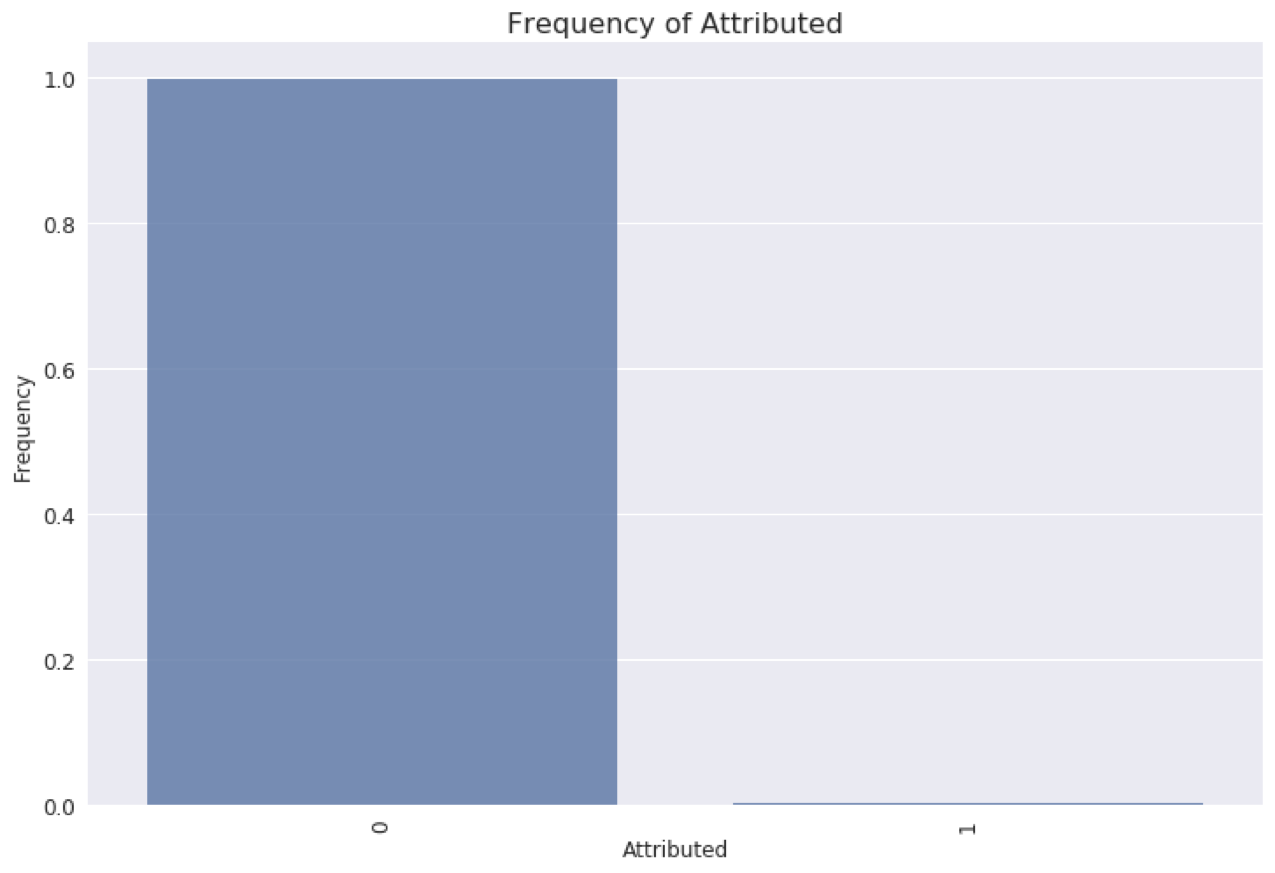
It found that the ratio between the “non-attributed” and “attributed” is 0.99773: 0.00227. This is a heavily imbalanced data. As the target positive class is only 0.227 % in the data set, which means it will be tough for machine learning model to classify the true class. As the fraud click is usually a very small portion in the real world, it is very common to deal with such heavily imbalanced data in fraud detection studies. 

Machine Learning algorithms tend to produce unsatisfactory classifiers when faced with imbalanced datasets. For any imbalanced data set, if the event to be predicted belongs to the minority class and the event rate is less than 5%, it is usually referred to as a rare event. Therefore, we implemented the so-called Data Level approach by using resampling techniques to deal with the imbalanced data before building machine learning classification models. 

We choose random over-sampling to increase the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample. The portion of attributed and non-attributed becomes 0.18568 and 0.81432. It should be noted that testing other sampling portion of attributed and non-attributed would help determine the best model and parameters. 

### Variable correlation coefficient

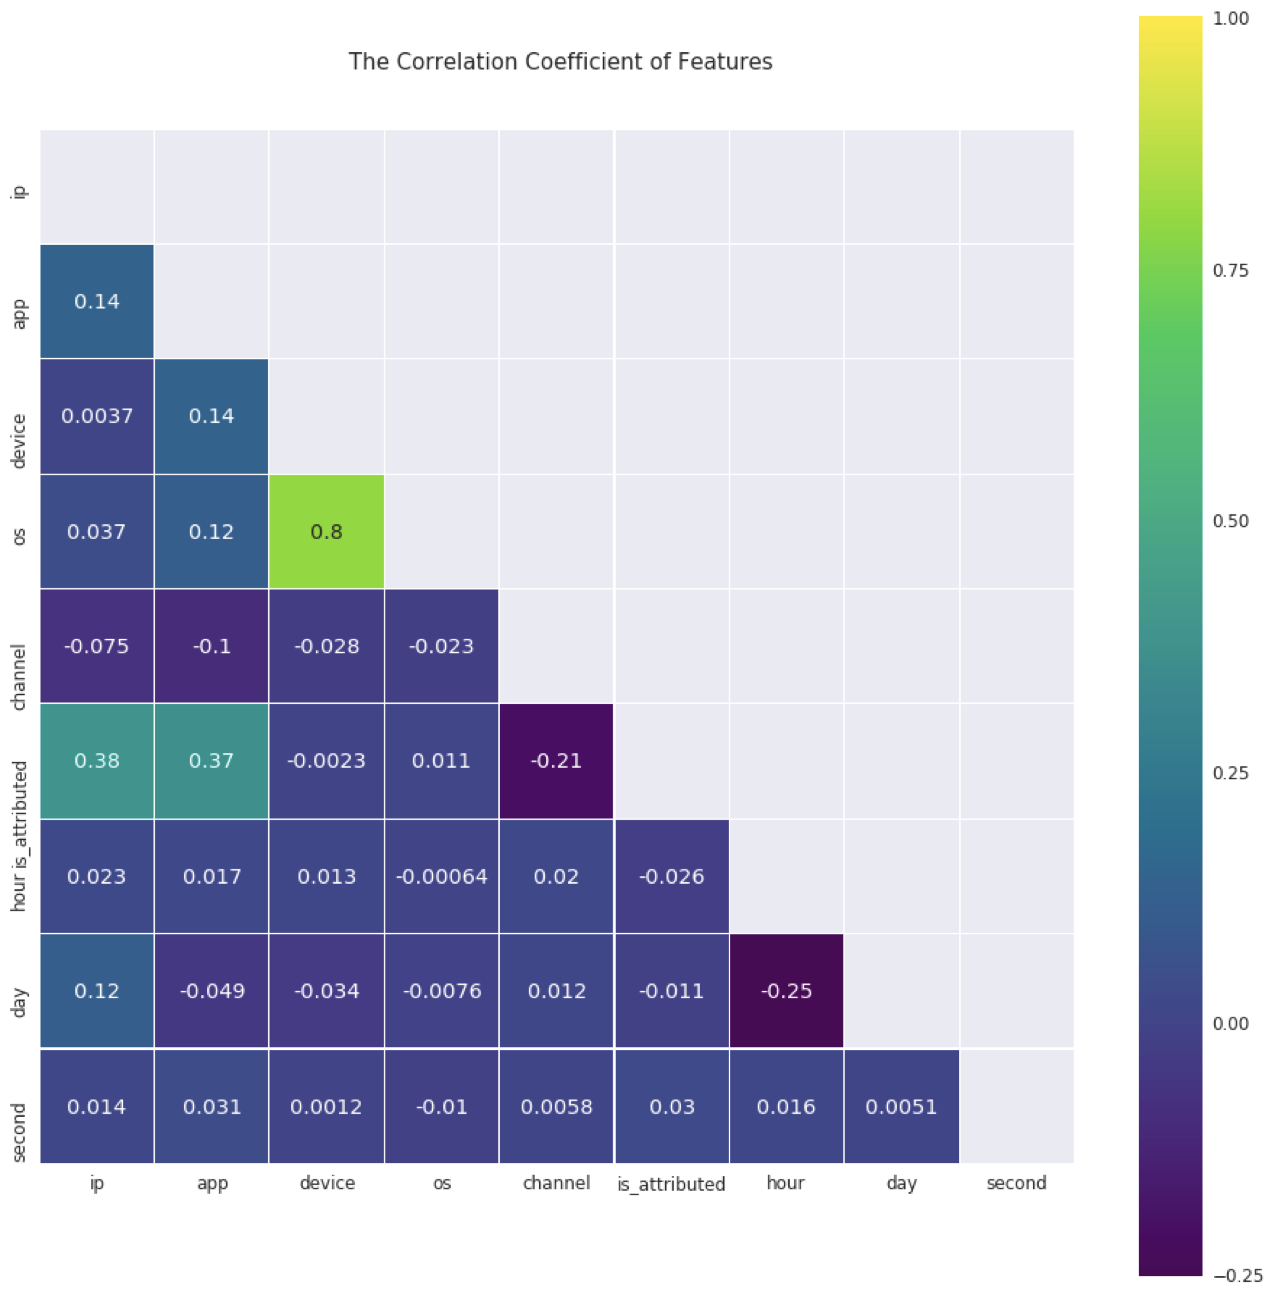
In the plot of correlation coefficient of variables, it is found that feature "ip", "app" and “channel” have highest correlation with "is_attributed", i.e, the target prediction class.<br>
In addition, kernel density plots regarding each feature distributions are also presented in the notebook (see 2.3). 

### Baseline Model and SVM Model

* Feed raw data to baseline model, SGDClassifier <br>
In the beginning, we apply stochastic gradient classifier (SGDClassifier) as our baseline model as a few parameters tuning embedded in sklearn pipeline. However, feature selection was not performed prior the baseline modeling. Prediction accuracy, confusion matrix, precision score, recall score and f1 score are used as evaluation metrics the model performance.  <br> 




* Apply SVM model with crafted data <br>
We performed feature engineering by adding 5 new features and delete one feature in data set, followed by applying support vector machine algorithm. Prediction accuracy, confusion matrix, precision score, recall score and f1 score are used as evaluation metrics the model performance.    


## Feature Selection and Ensemble Model

•	Select 5 features (principle components) by PCA  

In the feature selection portion, we adopted multiple methods, including univariate selection, recursive feature elimination and Principal Component Analysis (PCA) to choose 5 most important features from the data. It should be noted that unlike univariate selection, recursive feature elimination, PCA is a dimension reduction technique and the final 5 most important features are not comparable with features selected from other two methods. 

•	Fit multiple ML models using PCA selected features  

Using the 5 principle components from PCA as input data, we retrained multiple machine learning classification algorithms, including logistic regression, random forest, support vector machine and K-Nearest Neighbor (KNN).  Prediction accuracy, confusion matrix, precision score, recall score and f1 score are used as evaluation metrics the model performance.   

•	Fit ensemble ML models using PCA selected features  

It has been studies that ensemble learning methods will improve the performance of single classifiers when dealing with imbalanced data. With the goal to improve the performance of prediction on the imbalance data, we implemented three ensemble learning methods and select the best model with statistical significance. The three ensemble learning methods include voting ensemble model, boosting algorithms and bagging algorithms, (see 4.5). Prediction accuracy, confusion matrix, precision score, recall score and f1 score are used as evaluation metrics the model performance. 


## Result and Discussion 


Before applying random over sampling technique to the training and test set, all the ML models including the SGDClassifier, SVM model and ensemble learning model generate very high prediction accuracy (>0.99). However, all the prediction results are predicted as “non-attributed”. Since the “attributed” portion is only 0.227 %, they are treated as “outlier” when using these classifiers. 

After applying random over sampling technique to the training and test set to balance the target class portion, all the ML models including the SGDClassifier, SVM model and ensemble learning model generate high prediction accuracy as well as high F1 score. Table 1 shows prediction performance of all ML models from baseline to ensemble learning models. After we apply the models to true test set (i.e., data set that was not applied by random over sampling technique or used for training and validation for training ML models), we still obtain high prediction accuracy and moderate F1 score. Though there is still a number of records are classified as false negative, it demonstrates the random over sampling technique improves the ML model performance. In addition, from the ensemble learning methods result, we perform significance test to compare two best models: voting ensemble and bagging algorithms. Based on the t-test on the accuracy score, it is shown that bagging algorithms performs better than voting ensemble model with statistical significance. 


Table 1.   Prediction performance of ML models
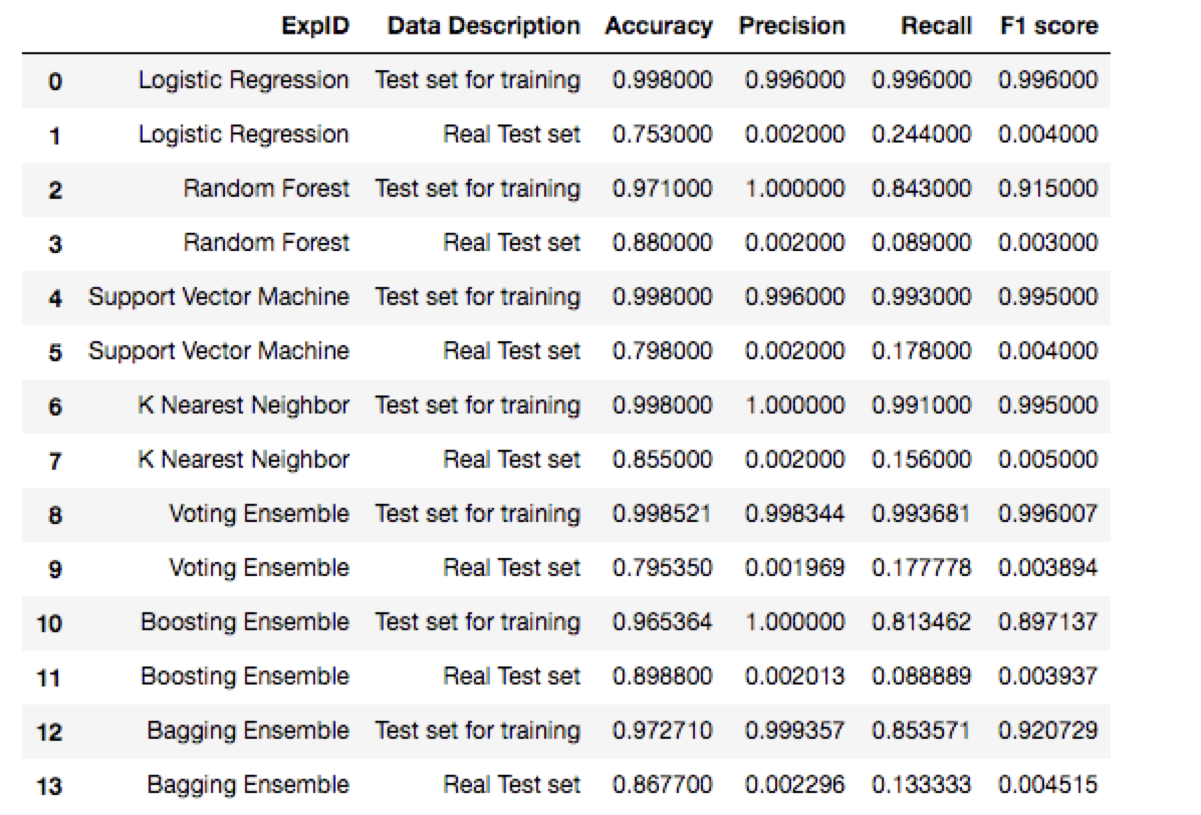

In this project, we applied random over sampling technique to deal with imbalanced data, implemented and tuned multiple ML algorithms and ensemble learning models. It is shown ensemble learning model with Decision Tree Classifier of bagging algorithm performs best among all the ML models. 


## Future Direction

To further improve the prediction performance on the imbalanced dataset, there are three directions can be explored. <br>
* Implement other sampling techniques<br>
First, implement other sampling techniques, such as Random Under-Sampling to balance class distribution by randomly eliminating majority class examples and synthetic minority oversampling technique (SMOTE).<br>
* Improve the feature selection method <br>
Second, improve the feature selection method. LASSO regression would be a more preferred method for feature selection. For example, logistic regression with LASSO regularization can be used as a baseline model and select the priori features based on the model. <br>
* Hyperparameter tuning on the ensemble learning models <br>
Third, hyperparameter tuning on the ensemble learning models. Here, hyperparameter tuning is not fully explored in current study. However, it would be more useful to tune the hyperparameters in ensemble learning models, such as weights in voting model, maximum tree depth in Decision Tree Classifier. 
